In [1]:
import pyodbc
import pandas as pd

# Configuração da conexão
server = 'Felipe\SQLEXPRESS'  # Exemplo: 'meuservidor.database.windows.net'
database = 'projeto'
username = 'sa'
password = '123456789'
driver = '{ODBC Driver 17 for SQL Server}'  # Confirme se tem este driver instalado

# Criando conexão
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
)

# Criando cursor
cursor = conn.cursor()

# Executando uma query SQL
query = "SELECT * FROM dbo.Kmeans"
df_kmeans = pd.read_sql(query, conn)

# Fechando a conexão
conn.close()

# Exibir as 5 primeiras linhas do DataFrame
print(df_kmeans.head())


   clients_id  gross_income  quantity            product_line brand  rating  \
0         265    355.377269         7  Electronic accessories     A       2   
1         147    289.305526        10  Electronic accessories     A       4   
2          86    300.503604         6  Electronic accessories     A       1   
3         140     49.283974         6  Electronic accessories     A       3   
4         199    117.725192         5  Electronic accessories     A       3   

   age  
0   39  
1   21  
2   65  
3   22  
4   42  


In [9]:
# Modifying the dataset to apply the KMeans
# Substitute the ',' for '.'
##df_kmeans['gross_income'] = df_kmeans['gross_income'].str.replace(',', '.')

# Converting to float
##df_kmeans['gross_income'] = df_kmeans['gross_income'].astype(float)

#Aggregating the columns
df_agg = df_kmeans.groupby('clients_id').agg({
    'gross_income': 'sum',
    #'quantity': 'sum',
    'product_line': 'nunique',
    #'brand': 'nunique',
    #'rating': 'mean',
    'age': 'mean'
}).reset_index()

In [10]:
from sklearn.preprocessing import StandardScaler

#Here we are normalizing the data, to avoid bigger scales between the values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_agg.iloc[:, 1:])

<function matplotlib.pyplot.show(close=None, block=None)>

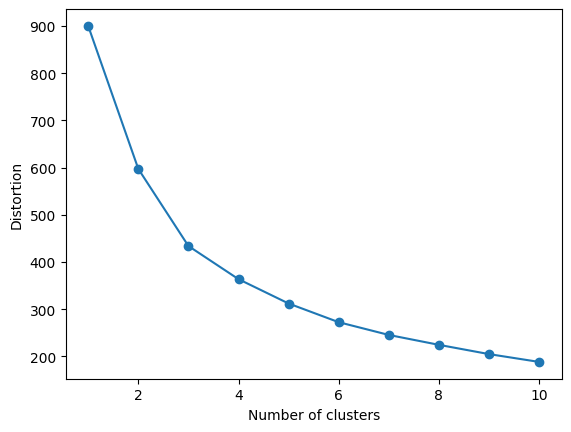

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Using Elbow method to define the number of clusters
distortions = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show

In [12]:
#Applying the KMeans
kmeans = KMeans(n_clusters = 3, random_state=42)
df_agg['clusters'] = kmeans.fit_predict(df_scaled)

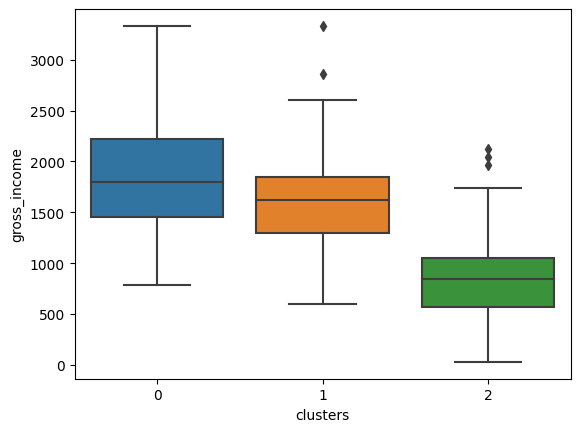

In [13]:
import seaborn as sns

sns.boxplot(x='clusters', y = 'gross_income', data = df_agg)
plt.show()

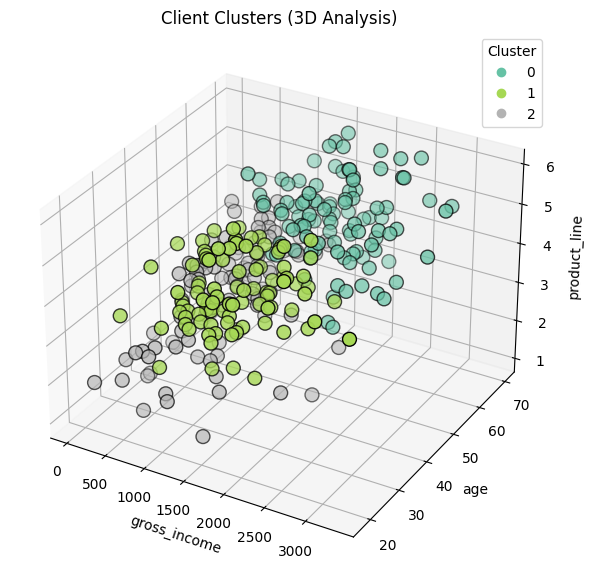

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Escolha 3 variáveis para análise
x = 'gross_income'
y = 'age'
z = 'product_line'

# Criação do gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos
scatter = ax.scatter(df_agg[x], df_agg[y], df_agg[z], c=df_agg['clusters'], cmap='Set2', s=100, edgecolor='black')

# Adicionando título e rótulos
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.set_title('Client Clusters (3D Analysis)')

# Adicionando a legenda
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


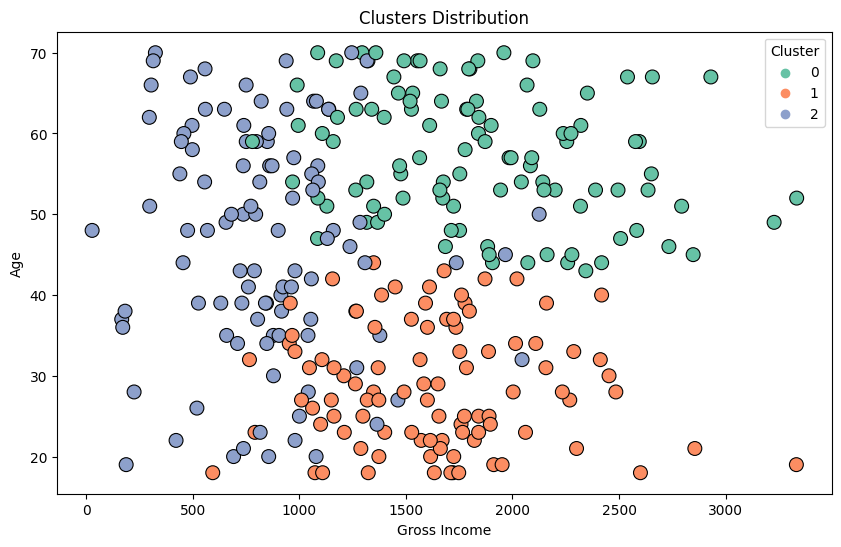

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg, x='gross_income', y='age', hue='clusters', palette='Set2', s=100, edgecolor='black')
plt.title('Clusters Distribution')
plt.xlabel('Gross Income')
plt.ylabel('Age')
plt.legend(title='Cluster')
plt.show()

In [17]:
from sqlalchemy import create_engine

#Selecting only the cliend_id and clusters from df_agg
dfKmeans = df_agg[['clients_id', 'clusters']]

# Connection String
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

# Database table name
kmean_table = 'dimKMeans'

# Export Dataframe
dfKmeans.to_sql(kmean_table, con=engine, if_exists='replace', index=False)